### Poisson problem with Dirichlet boundary conditions

Let's solve together the following problem:
$$
\begin{cases}
\Delta u &= f, \quad \text{in $\Omega$} \\
       u &= g_D, \quad \text{over $\Gamma$} 
\end{cases}
$$
with $\Omega$ the usual crown section, for the time being
$$
g_D = 0,
$$
and $f$ the usual function we define on this domain.






In [1]:
import numpy as np
import scipy.sparse as sps
import meshio
import matplotlib.pyplot as plt
import time

In [2]:
# I got tired of re-defining everything everytime.
import myfavfunctions as mff
# but pay very much attention, we're not in MATLAB, Python isn't so kind: if you change myfavfunctions.py
# Python won't know this until you don't restart the kernel!!

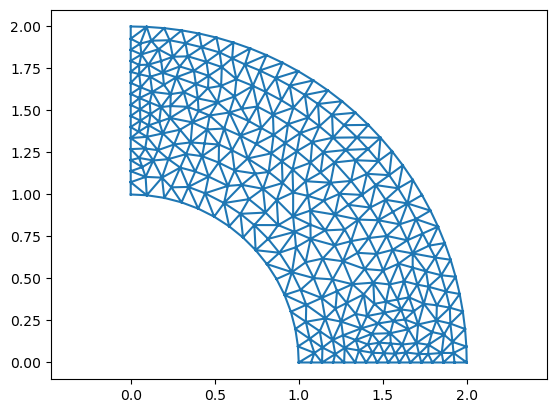

In [3]:
# mesh = meshio.read('../mesh-files/crown.vtu')
mesh = meshio.read('../mesh-files/crown_hard.vtu')
# mesh = meshio.read('../mesh-files/crown_harder.vtu')
# mesh = meshio.read('../mesh-files/crown_hardest.vtu')

%matplotlib inline
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

plt.triplot( mesh.points[:,0], mesh.points[:,1], triangles = mesh.cells[0].data )
plt.show()


Points = mesh.points[:,:2]  # for sake of brevity (had to set :2 bcause meshio is stupid or something idk)
CList  = mesh.cells[0].data # for sake of brevity
B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )
iBt = np.linalg.inv( B ).transpose( (0,2,1) )

In [4]:
def fun( x ):
    r = 1
    R = 2
    z =   np.sin( np.arccos( x[:,0] / np.sqrt( np.sum( x**2,1 ) ) ) ) \
        * np.cos( np.arccos( x[:,0] / np.sqrt( np.sum( x**2,1 ) ) ) ) \
        * ( np.sqrt( np.sum( x**2,1 ) ) - r ) * ( R - np.sqrt( np.sum( x**2,1 ) ) )
    
    return z[:,None]

In [5]:
# M = mff.mass_assembly ( Points, CList, dtB ) # not necessary
S = mff.stiff_assembly( Points, CList, dtB, iBt )

# assemble rhs
Nv     = Points.shape[0]
Nc     =  CList.shape[0]
d_elem =  CList.shape[1] - 1

X, W = mff.simplexQuadrature( 4, d_elem )
rhs = np.zeros( ( Nc, CList.shape[1] ) ) # we make space for the Nc * CList.shape[1] contributions!
for q in range( W.shape[0] ):
    N0 = mff.phi( d_elem, X[q,:][None,:] )
    p = B @ X[q,:] + Points[CList[:,0]]
    rhs = rhs + ( fun( p ) @ N0 ) * ( dtB * W[q] )[:,None]
rhs = np.bincount( CList.reshape(-1,order='F'), rhs.reshape(-1,order='F'), Nv ) 

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


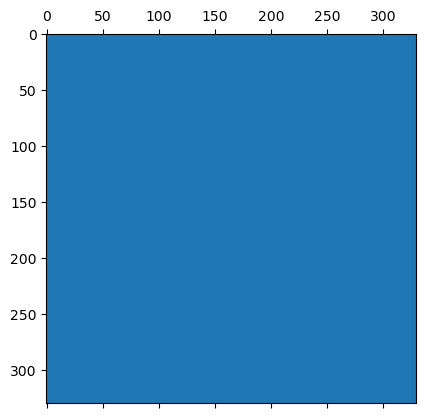

In [6]:
# Solving part :3

# find Dirichlet nodes 
# How? Easy:
# a. find external edges
# b. find border points by taking once the vertices forming the external edges

ee = mff.external_subsimplexes( CList )
Dir = np.unique( ee )
# print( Dir.shape ) # count them with the finger if you don't trust me

S_ = S.copy()
S_[ Dir,: ] = 0 # bad!!! (inefficient, if you spy this you'll find lots of present entries)
S_ = S_.tocoo()
S_.row = np.append( S_.row, Dir )
S_.col = np.append( S_.col, Dir )
S_.data = np.append( S_.data, np.ones_like( Dir ) )
S_ = S_.tocsr()

plt.spy( S_, precision = 'present' )

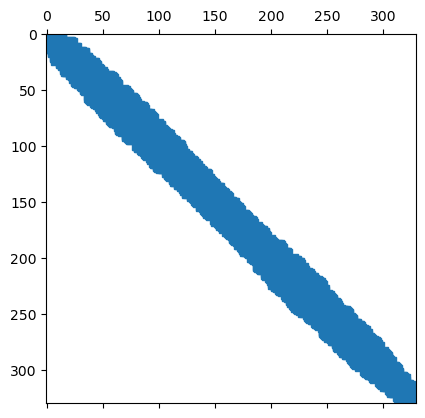

In [7]:
S_.eliminate_zeros()
plt.spy( S_, precision = 'present' )

In [8]:
# Fix up rhs
rhs_ = rhs.copy()
rhs_[ Dir ] = 0

In [9]:
# Now solve the linear system
t = time.time()
sol = sps.linalg.spsolve( - S_, rhs_ )
print('Elapsed time %1.3f seconds.' % (time.time() - t))

Elapsed time 0.003 seconds.


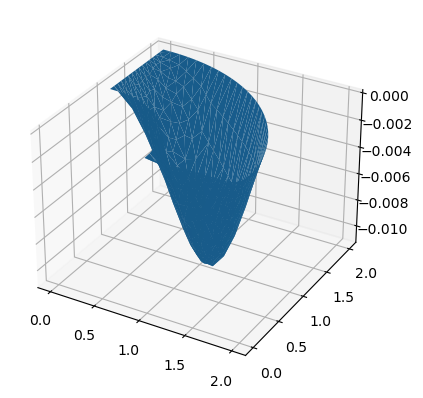

In [10]:
# and plot solution
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(Points[:,0], Points[:,1], - sol, triangles = CList )
plt.show()

In [11]:
# Alternative method to avoid the pain of adding nonsense zeros and stuff
tgv = 10**14

S_tgv      = S.copy()
S_tgv      = S_tgv.tocoo()
S_tgv.row  = np.append( S_tgv.row, Dir )
S_tgv.col  = np.append( S_tgv.col, Dir )
S_tgv.data = np.append( S_tgv.data, np.ones_like( Dir ) *  - tgv )
S_tgv      = S_tgv.tocsr()

# Fix up rhs
rhs_tgv = rhs.copy()
rhs_tgv[ Dir ] = np.zeros_like( Dir ) * tgv

# Solve
t = time.time()
sol_tgv = sps.linalg.spsolve( - S_tgv, rhs_tgv )
print('Elapsed time %1.3f seconds.' % (time.time() - t))

np.linalg.norm( sol - sol_tgv ) / np.linalg.norm( sol )

Elapsed time 0.002 seconds.


4.0382778090711354e-15

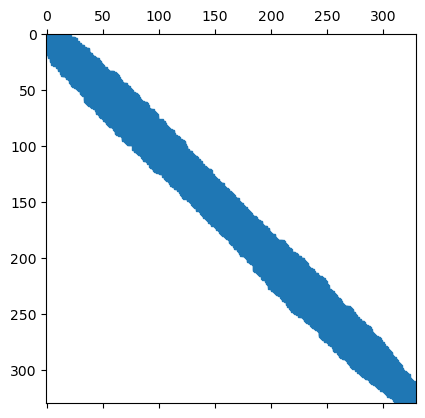

In [12]:
%matplotlib inline

plt.spy( S_tgv, precision = 'present' )

In [13]:
# now with grownups tools
from petsc4py import PETSc

solver_parameters = {
            "iterativeSolver"       : 'cg',
            "preconditioner"        : 'cholesky', # 'gamg' visit https://petsc.org/main/manualpages/PC/
            "relativeTolerance"     : 1e-8,
            "absoluteTolerance"     : 1e-8,
            "maximumIterations"     : 1e+2,
            "setInitialGuessNonzero": False,
            }


# build PETSc context
A = PETSc.Mat().createAIJ( size = ( Nv, Nv ), csr = ( S_tgv.indptr, S_tgv.indices, - S_tgv.data ) )
dirichletPoisson = PETSc.KSP().create() # creating a KSP object
dirichletPoisson.setOperators( A )
dirichletPoisson.setType(                solver_parameters["iterativeSolver"       ] ) # decide iterative solver
dirichletPoisson.getPC().setType(        solver_parameters["preconditioner"        ] ) # set preconditioner
dirichletPoisson.setTolerances( rtol   = solver_parameters["relativeTolerance"     ], \
                                atol   = solver_parameters["absoluteTolerance"     ], \
                                max_it = solver_parameters["maximumIterations"     ] )
dirichletPoisson.setInitialGuessNonzero( solver_parameters["setInitialGuessNonzero"] )

# initialize PETSc solution vector
solution        = PETSc.Vec().createSeq( Nv ) 
# initialize PETSc     rhs vector
righthandside   = PETSc.Vec().createSeq( Nv ) 
righthandside.setValues( range( Nv ), rhs_tgv )


t = time.time()
dirichletPoisson.solve( righthandside, solution ) # A is implicit inside the context
print('Elapsed time %1.3f seconds.' % (time.time() - t))
sol_petsc = solution.getArray()


np.linalg.norm( sol - sol_petsc ) / np.linalg.norm( sol )

Elapsed time 0.001 seconds.


4.248429979832354e-15

Elapsed time 0.010 seconds.
2.2263877299080367e-07


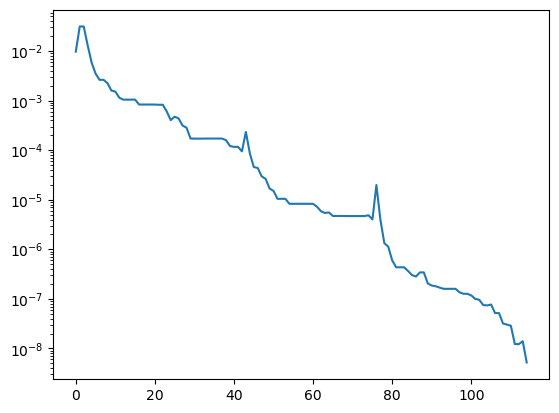

In [14]:
# Matrix-free

from petsc4py import PETSc

solver_parameters = {
            "iterativeSolver"       : 'bcgs', # 'cg'
            "preconditioner"        : 'cholesky', # 'gamg' visit https://petsc.org/main/manualpages/PC/
            "relativeTolerance"     : 1e-8,
            "absoluteTolerance"     : 1e-8,
            "maximumIterations"     : 1e+3,
            "setInitialGuessNonzero": False,
            }

class laplace(object):
    def __init__(self,A):
        self.A  = A
        self.Nv = A.shape[0]

    def mult(self, mat, X, Y):
        Y.setValues( range( self.Nv ), self.A @ X.getArray() )
        
A = PETSc.Mat().createPython( Nv, Nv )
mylap = laplace( - S_tgv )
A.setPythonContext( mylap )


mf_dirichletPoisson = PETSc.KSP().create() # creating a KSP object
mf_dirichletPoisson.setOperators( A )
mf_dirichletPoisson.setType(                solver_parameters["iterativeSolver"       ] ) # decide iterative solver
# mf_dirichletPoisson.getPC().setType(        solver_parameters["preconditioner"        ] ) # set preconditioner
mf_dirichletPoisson.setTolerances( rtol   = solver_parameters["relativeTolerance"     ], \
                                   atol   = solver_parameters["absoluteTolerance"     ], \
                                   max_it = solver_parameters["maximumIterations"     ] )
mf_dirichletPoisson.setInitialGuessNonzero( solver_parameters["setInitialGuessNonzero"] )
# mf_dirichletPoisson.setFromOptions() # boh non so cosa sia
mf_dirichletPoisson.setConvergenceHistory()


# initialize PETSc solution vector
solution        = PETSc.Vec().createSeq( Nv ) 
# initialize PETSc     rhs vector
righthandside   = PETSc.Vec().createSeq( Nv ) 
righthandside.setValues( range( Nv ), rhs_tgv )

t = time.time()
mf_dirichletPoisson.solve( righthandside, solution ) # A is implicit inside the context
print('Elapsed time %1.3f seconds.' % (time.time() - t))
sol_petsc = solution.getArray()


print( np.linalg.norm( sol - sol_petsc ) / np.linalg.norm( sol ) )


residuals = mf_dirichletPoisson.getConvergenceHistory()
plt.semilogy(residuals)